In [1]:
from os.path import dirname
import os
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
%load_ext autoreload
%autoreload 2
import brandear_est as be

In [9]:
INPUT_DIR = os.path.join(os.getcwd(), "../../data/input")
IMD_DIR = os.path.join(os.getcwd(), "../../data/intermediate/")
IMD_INPUT_DIR = os.path.join(IMD_DIR, "pickled_inputs")

dset_to_period = {
    "train": {"oldest": datetime.datetime(2019, 9, 3, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 10, 0, 0, 0)},
    "valid_for_train": {"oldest": datetime.datetime(2019, 9, 10, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 17, 0, 0, 0),},    
    "valid_for_sub": {"oldest": datetime.datetime(2019, 9, 17, 0, 0, 0),
              "newest": datetime.datetime(2019, 9, 24, 0, 0, 0),},
    "submission": {"oldest": datetime.datetime(2019, 9, 24, 0, 0, 0),
              "newest": datetime.datetime(2019, 10, 1, 0, 0, 0),},    
}

In [11]:
# 元データ読み込み
auction= pd.read_pickle(IMD_INPUT_DIR + "/auction.pkl")
watch= pd.read_pickle(IMD_INPUT_DIR + "/watch.pkl")
bid= pd.read_pickle(IMD_INPUT_DIR + "/bid.pkl")
bid_success= pd.read_pickle(IMD_INPUT_DIR + "/bid_success.pkl")
sample_sub = pd.read_csv(INPUT_DIR + "/sample_submission.csv")    

sub_users = sample_sub[["KaiinID"]].drop_duplicates()


In [8]:
watch_auc = watch.merge(auction, on="AuctionID", how="inner")

In [9]:
target_actions = be.extract_target_actions(watch, bid, dset_to_period["valid_for_sub"])
target_users = target_actions[["KaiinID"]].drop_duplicates()

In [10]:
valid_aucs = be.extract_valid_aucs(auction, watch, bid_success, dset_to_period["valid_for_sub"])

In [11]:
def get_mode_pairs(watch_auc, target_users, valid_aucs, key):
    user_modes= (
        watch_auc.merge(target_users, on=["KaiinID"], how="inner")[["KaiinID", key]]
        .groupby(["KaiinID", key], as_index=False).size().unstack().idxmax(1).reset_index()
        .rename(columns={0: key})
    )
    mode_pairs = (
        auction[[key, "AuctionID"]].merge(valid_aucs, on="AuctionID", how="inner")
        .merge(user_modes, on=key, how="inner")
    )
    return mode_pairs

In [52]:
def get_user_mode(watch_auc, target_users, key):
    user_modes= (
        watch_auc.merge(target_users, on=["KaiinID"], how="inner")[["KaiinID", key]]
        .groupby(["KaiinID", key], as_index=False).size().unstack().idxmax(1).reset_index()
        .rename(columns={0: key})
    )
    return user_modes

In [111]:
watch_auc.groupby(["KaiinID", "BrandID"], as_index=False).size().reset_index().rename(columns={0: key})

,KaiinID,BrandID,LineID
0,22,10,2
1,22,12,28
2,22,19,3
3,22,30,2
4,22,47,21
...,...,...,...
776810,277891,10326,1
776811,277891,10364,1
776812,277891,10438,20
776813,277891,10594,7


In [36]:
mode_pairs = get_mode_pairs(watch_auc, target_users, valid_aucs, "BrandID")

In [37]:
print(mode_pairs.shape)
print(mode_pairs.merge(target_actions, on=["KaiinID", "AuctionID"], how="inner").shape)

(41191423, 3)
(21200, 5)


,AuctionID
0,4066465
1,622037
2,3447030
3,957658
5,1242382
...,...
816273,3636243
816274,2927568
816275,976663
816276,739919


In [86]:
brand_mode = get_user_mode(watch_auc, target_users, "BrandID")
gend_mode = get_user_mode(watch_auc, target_users, "DanjobetsuID")
color_mode = get_user_mode(watch_auc, target_users, "ColorID")
geng_mode = get_user_mode(watch_auc, target_users, "GenreGroupID") 
gen_mode = get_user_mode(watch_auc, target_users, "GenreID") 
con_mode = get_user_mode(watch_auc, target_users, "ConditionID") 

In [87]:
q_df = pd.concat([
    brand_mode,
    gend_mode.drop("KaiinID", axis=1),
    color_mode.drop("KaiinID", axis=1), 
    geng_mode.drop("KaiinID", axis=1),
    gen_mode.drop("KaiinID", axis=1),
    con_mode.drop("KaiinID", axis=1)], axis=1)

In [93]:
q_re = q_df.merge(
    auction.merge(valid_aucs, on="AuctionID", how="inner"),
    on=["DanjobetsuID", "ColorID", "GenreGroupID", "GenreID", "ConditionID"], how="inner")

In [94]:
q_re.head()

,KaiinID,BrandID_x,DanjobetsuID,ColorID,GenreGroupID,GenreID,ConditionID,AuctionID,ShouhinShubetsuID,ShouhinID,SaishuppinKaisuu,BrandID_y,LineID,SankouKakaku,CreateDate
0,22,12,0,0,312,321,6,4079311,1,1132159,0,1011,0,1000,2019-07-27 09:31:45
1,22,12,0,0,312,321,6,3036982,1,2651629,334,1,0,10000,2019-07-27 09:31:48
2,22,12,0,0,312,321,6,3747358,1,1171525,0,32,0,2500,2019-07-27 09:31:48
3,22,12,0,0,312,321,6,442922,1,1282599,0,119,0,5000,2019-07-27 09:32:09
4,22,12,0,0,312,321,6,813198,1,640133,0,2479,0,6000,2019-07-27 09:32:13


In [95]:
print(q_re.shape)
print(q_re[["KaiinID", "AuctionID"]].merge(target_actions, on=["KaiinID", "AuctionID"], how="inner").shape)

(35518961, 15)
(5960, 4)


In [96]:
valid_aucs.shape

(751419, 1)

In [ ]:
for colset in colsets
    be.to_pickle(FEATURE)

In [116]:
get_value_counts(watch_auc, ["KaiinID", "BrandID"], "watch", dset_to_period["valid_for_sub"]["oldest"], "TourokuDate")

,KaiinID,BrandID,watch_KaiinID_BrandID_cnt
0,22,10,2
1,22,12,28
2,22,19,3
3,22,30,2
4,22,47,21
...,...,...,...
776810,277891,10326,1
776811,277891,10364,1
776812,277891,10438,20
776813,277891,10594,7


In [16]:
def extract_target_actions(watch, bid, period):
    watch_actioned = (
        watch.loc[(watch["TourokuDate"] >= period["oldest"]) & (watch["TourokuDate"] < period["newest"]),
                  ["KaiinID", "AuctionID"]]
    )
    bid_actioned = (
        bid.loc[(bid["ShudouNyuusatsuDate"] >= period["oldest"]) & (bid["ShudouNyuusatsuDate"] < period["newest"]),
                ["KaiinID", "AuctionID"]]
    )
    # 学習用データの際は正解データを作成する
    watch_actioned["watch_actioned"] = 1
    bid_actioned["bid_actioned"] = 1

    target_actions = (
        watch_actioned
        .merge(bid_actioned, on=["KaiinID", "AuctionID"], how="outer")
        .drop_duplicates()
        .fillna(0)
    )

    return target_actions


def arrange_dtime_condition(watch, bid, auction, period):
    retval = (
        watch[watch["TourokuDate"] <= period["oldest"]],
        bid[bid["ShudouNyuusatsuDate"] <= period["oldest"]],
        auction[auction["CreateDate"] < period["newest"]]        
    )
    return retval

def arrange_inputs(watch, bid, auction, period):
    watch_t_arranged, bid_t_arranged, auction_arranged = (
        arrange_dtime_condition(watch=watch, bid=bid, auction=auction, period=period)
    )
    
    retval =  (
        watch_t_arranged.merge(auction, on="AuctionID", how="left"),
        bid_t_arranged.merge(auction, on="AuctionID", how="left"),
        auction_arranged
    )
    return retval

### 正解データの分布を確認(業者がいないか)

- お気に入りに関しては、正解データのユーザーのうち半数以上が業者っぽい？
    - watch_cntは50〜200くらいで業者を取り除けそう？

In [24]:
dset_type = "valid_for_sub"
targets = extract_target_actions(watch, bid, dset_to_period[dset_type])
watch_arranged, bid_arranged, auction_arranged = (
    arrange_inputs(watch=watch, bid=bid, auction=auction, period=dset_to_period[dset_type])
)
watch_cnt = watch_arranged.groupby("KaiinID").size().reset_index().rename(columns={0: "watch_cnt"})
bid_cnt = bid_arranged.groupby("KaiinID").size().reset_index().rename(columns={0: "bid_cnt"})

In [25]:
targets_cnt = targets[["KaiinID", "watch_actioned", "bid_actioned"]].groupby("KaiinID", as_index=False).sum()
targets_cnts = targets_cnt.merge(watch_cnt, on="KaiinID", how="left").merge(bid_cnt, on="KaiinID", how="left").fillna(0)

(array([1373.,  484.,  291.,  207.,  198.,  180.,  149.,  131.,  151.,
         104.,  103.,   90.,   99.,   75.,   76.,   90.,   79.,   75.,
          61.,   46.,   45.,   50.,   49.,   48.,   46.,   52.,   45.,
          24.,   32.,   41.,   33.,   33.,   39.,   36.,   29.,   37.,
          35.,   32.,   29.,   31.,   25.,   29.,   22.,   26.,   17.,
          29.,   16.,   20.,   14.,   21.,   20.,   22.,   13.,   21.,
          14.,   20.,   18.,   13.,   21.,   20.,   11.,   22.,   17.,
          21.,   14.,   21.,    6.,   15.,   13.,   11.,   12.,   19.,
          12.,    7.,   16.,   10.,    9.,    8.,   13.,   10.,    7.,
           8.,   11.,    9.,    9.,    7.,    9.,   12.,    8.,   10.,
           7.,   14.,    9.,   11.,    7.,    9.,    8.,    6.,    7.,
           6.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.

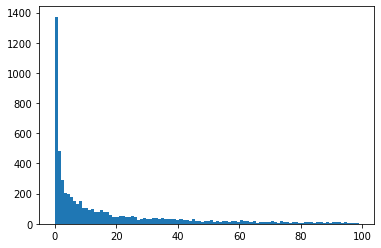

In [49]:
plt.hist(targets_cnts["bid_cnt"][targets_cnts["bid_cnt"] < 100],bins=100)

(array([1408.,  356.,  270.,  199.,  177.,  163.,  128.,  137.,  126.,
         129.,   94.,  114.,  102.,   87.,  104.,   85.,   72.,   64.,
          64.,   78.,   68.,   52.,   57.,   46.,   53.,   47.,   48.,
          35.,   30.,   48.,   41.,   43.,   45.,   35.,   29.,   36.,
          36.,   36.,   39.,   30.,   31.,   37.,   24.,   33.,   25.,
          24.,   20.,   32.,   27.,   31.,   17.,   27.,   25.,   21.,
          20.,   18.,   17.,   28.,   23.,   16.,   16.,   23.,   19.,
          20.,   15.,   18.,   18.,    9.,   15.,   16.,   23.,   20.,
           8.,   13.,   10.,   12.,   11.,    9.,   13.,    8.,    9.,
          10.,   17.,    8.,   17.,    5.,    8.,    5.,   10.,    8.,
           7.,    2.,    9.,    8.,    9.,    6.,    5.,    6.,    9.,
           3.]),
 array([  0.  ,   9.98,  19.96,  29.94,  39.92,  49.9 ,  59.88,  69.86,
         79.84,  89.82,  99.8 , 109.78, 119.76, 129.74, 139.72, 149.7 ,
        159.68, 169.66, 179.64, 189.62, 199.6 , 209.58, 21

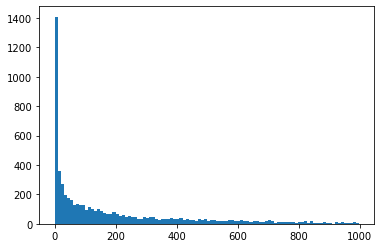

In [34]:
plt.hist(targets_cnts["watch_cnt"][targets_cnts["watch_cnt"] < 1000],bins=100)

In [50]:
print(targets_cnts["watch_actioned"].sum())
print(targets_cnts[targets_cnts["watch_cnt"] < 400]["watch_actioned"].sum())
print(targets_cnts[targets_cnts["watch_cnt"] < 200]["watch_actioned"].sum())
print(targets_cnts[targets_cnts["watch_cnt"] < 100]["watch_actioned"].sum())
print(targets_cnts.describe())
print(targets_cnts[targets_cnts["watch_cnt"] < 400].describe())
print(targets_cnts[targets_cnts["watch_cnt"] < 200].describe())
print(targets_cnts[targets_cnts["watch_cnt"] < 100].describe())
targets_cnts[targets_cnts["watch_cnt"] < 200].sort_values("watch_cnt", ascending=False).head(30)

85070.0
34050.0
24288.0
16755.0
             KaiinID  watch_actioned  bid_actioned     watch_cnt      bid_cnt  \
count    6344.000000     6344.000000   6344.000000   6344.000000  6344.000000   
mean   138069.166929       13.409521      1.589691    391.867276    54.454918   
std     79236.138381       33.248519      6.072464   1050.261997   223.696213   
min        22.000000        0.000000      0.000000      0.000000     0.000000   
25%     69401.750000        1.000000      0.000000     14.000000     1.000000   
50%    138801.000000        4.000000      0.000000    108.000000     9.000000   
75%    204641.500000       13.000000      1.000000    386.000000    37.000000   
max    277891.000000      820.000000    163.000000  24371.000000  5585.000000   

       bid_cnt_rank  
count   6344.000000  
mean    3172.500000  
std     1821.551511  
min        1.000000  
25%     1592.500000  
50%     3128.500000  
75%     4729.500000  
max     5658.000000  
             KaiinID  watch_actioned  bi

,KaiinID,watch_actioned,bid_actioned,watch_cnt,bid_cnt,bid_cnt_rank
4960,214541,5.0,0.0,199.0,12.0,2834.0
5713,248049,49.0,5.0,199.0,15.0,2588.5
3667,157984,4.0,0.0,199.0,4.0,3890.5
6204,271768,1.0,0.0,199.0,18.0,2359.0
6205,271853,1.0,0.0,199.0,18.0,2359.0
3735,161266,9.0,0.0,199.0,1.0,4729.5
4106,176356,64.0,0.0,199.0,10.0,3025.0
1262,56184,3.0,0.0,199.0,25.0,2018.5
2052,90557,7.0,0.0,198.0,1.0,4729.5
3314,144433,15.0,0.0,198.0,14.0,2671.5


In [48]:
print(targets_cnts["bid_actioned"].sum())
print(targets_cnts[targets_cnts["bid_cnt"] < 100]["bid_actioned"].sum())
print(targets_cnts[targets_cnts["bid_cnt"] < 50]["bid_actioned"].sum())
print(targets_cnts[targets_cnts["bid_cnt"] < 30]["bid_actioned"].sum())
print(targets_cnts.describe())
print(targets_cnts[targets_cnts["bid_cnt"] < 100].describe())
print(targets_cnts[targets_cnts["bid_cnt"] < 50].describe())
print(targets_cnts[targets_cnts["bid_cnt"] < 30].describe())
targets_cnts[targets_cnts["bid_cnt"] < 30].sort_values("bid_cnt", ascending=False).head(30)

10085.0
5042.0
3823.0
3097.0
             KaiinID  watch_actioned  bid_actioned     watch_cnt      bid_cnt  \
count    6344.000000     6344.000000   6344.000000   6344.000000  6344.000000   
mean   138069.166929       13.409521      1.589691    391.867276    54.454918   
std     79236.138381       33.248519      6.072464   1050.261997   223.696213   
min        22.000000        0.000000      0.000000      0.000000     0.000000   
25%     69401.750000        1.000000      0.000000     14.000000     1.000000   
50%    138801.000000        4.000000      0.000000    108.000000     9.000000   
75%    204641.500000       13.000000      1.000000    386.000000    37.000000   
max    277891.000000      820.000000    163.000000  24371.000000  5585.000000   

       bid_cnt_rank  
count   6344.000000  
mean    3172.500000  
std     1821.551511  
min        1.000000  
25%     1592.500000  
50%     3128.500000  
75%     4729.500000  
max     5658.000000  
             KaiinID  watch_actioned  bid_a

,KaiinID,watch_actioned,bid_actioned,watch_cnt,bid_cnt,bid_cnt_rank
3351,145702,30.0,0.0,184.0,29.0,1871.0
1857,81754,34.0,0.0,1284.0,29.0,1871.0
746,32528,6.0,0.0,138.0,29.0,1871.0
347,15504,15.0,0.0,1255.0,29.0,1871.0
1752,76834,3.0,3.0,35.0,29.0,1871.0
2911,128495,8.0,0.0,208.0,29.0,1871.0
45,1844,30.0,1.0,1261.0,29.0,1871.0
1921,84387,14.0,2.0,318.0,29.0,1871.0
2148,94752,1.0,2.0,39.0,29.0,1871.0
2753,121905,1.0,0.0,202.0,29.0,1871.0
